#### CS20M059 Shibobrota Das | CS20M007 Abhishek Kumar

## Setup

In [6]:
!pip install wandb -qqq

In [7]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import GradientTape
from tensorflow import keras
import pandas as pd
import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, SimpleRNNCell, LSTMCell, GRUCell
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
import time
import sys
import datetime
from sklearn.utils import shuffle
import wandb
# import nltk
import csv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

print("Using numpy:",np.__version__)
print("Using tensorflow:",tf.__version__)
print("Using keras:",keras.__version__)
print("Using pandas:",pd.__version__)

Using numpy: 1.19.5
Using tensorflow: 2.5.0
Using keras: 2.5.0
Using pandas: 1.1.5


In [57]:
wandb.init(project='Assignment 3', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/DL-A3 Dataset/dakshina_dataset_v1.0/hi/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DL-A3 Dataset/dakshina_dataset_v1.0/hi


#### Load Data

In [10]:
val_df = pd.read_csv("./lexicons/hi.translit.sampled.dev.tsv", sep='\t', header=None)
train_df = pd.read_csv("./lexicons/hi.translit.sampled.train.tsv", sep='\t', header=None)
test_df = pd.read_csv("./lexicons/hi.translit.sampled.test.tsv", sep='\t', header=None)
print("Data Loaded to Dataframes!")

Data Loaded to Dataframes!


In [11]:
%cd '/content/drive/My Drive/A3-checkpoints/'

/content/drive/My Drive/A3-checkpoints


#### Dataset Samples

In [12]:
train_df.sample(n=3)

,0,1,2
8322,कुशवाहा,kushvaha,1
41944,सेंसर्स,sensors,3
25312,फलोदी,phalodi,1


## Preparing Dataset

In [13]:
sos = "@"
eos = "#"

In [14]:
class LexDataset:
    def __init__(self, input_tensor, target_tensor, batch_size):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor
        self.batch = tf.data.Dataset.from_tensor_slices((self.input_tensor, self.target_tensor)).shuffle(len(self.input_tensor)).batch(batch_size, drop_remainder=True)

In [15]:
class TransliterationDatatset:
    def __init__(self, df_list, batch_size = 64):
        
        self.input_tokenizer = None
        self.target_tokenizer = None
        self.train = None
        self.val = None
        self.test = None
        self.batch_size = batch_size
        # Load Data
        self.load_dataset(df_list)
        # Other parameters
        self.num_input_tokens = len(self.input_tokenizer.index_word)+1
        self.num_target_tokens = len(self.target_tokenizer.index_word)+1
        self.max_input_seq_length = np.max([self.train.input_tensor.shape[1], self.val.input_tensor.shape[1], self.test.input_tensor.shape[1]])
        self.max_target_seq_length = np.max([self.train.target_tensor.shape[1], self.val.target_tensor.shape[1], self.test.target_tensor.shape[1]])
        
    def preprocess_word(self, w):
        return sos + str(w) + eos
    
    def print_input(self, tensor):
        for t in tensor:
            if t != 0:
                print(f'{t} ----> {self.input_tokenizer.index_word[t]}')
                
    def print_target(self, tensor):
        for t in tensor:
            if t != 0:
                print(f'{t} ----> {self.target_tokenizer.index_word[t]}')
    
    def create_dataset(self, data_frame):
        input_words = []
        target_words = []
        # Shuffle the data_frame before creating dataset
        df = data_frame
        for i in range(5):
            df = shuffle(df)
        for x, y in zip(df[1], df[0]):
            input_words.append(self.preprocess_word(x))
            target_words.append(self.preprocess_word(y))
        return (input_words, target_words)
    
    def load_dataset(self, df_list):
        # df_list should have train -> val -> test in sequence
        
        self.input_tokenizer = Tokenizer(num_words = None, char_level = True)
        self.target_tokenizer = Tokenizer(num_words = None, char_level = True)
        
        ds_list = []
        
        for df in df_list:
            # Get the words list
            (input_words, target_words) = self.create_dataset(df)
            # Fit on the set of words
            self.input_tokenizer.fit_on_texts(input_words)
            self.target_tokenizer.fit_on_texts(target_words)
            ds_list.append((input_words, target_words))
                    
        self.target_tokenizer.index_word.update({0:" "})
        self.input_tokenizer.index_word.update({0:" "})
        
        input_word_len = []
        target_word_len = []
        
        tensor_list = []
        
        for i, (input_words, target_words) in enumerate(ds_list):
            input_tensor = self.input_tokenizer.texts_to_sequences(input_words)
            target_tensor = self.target_tokenizer.texts_to_sequences(target_words)
            tensor_list.append((input_tensor, target_tensor))
            input_word_len.append(np.max([len(x) for x in input_tensor]))
            target_word_len.append(np.max([len(x) for x in target_tensor]))
        
        for i, (input_tensor, target_tensor) in enumerate(tensor_list):
            
            input_tensor = pad_sequences(input_tensor, padding='post', maxlen = np.max(input_word_len))
            target_tensor = pad_sequences(target_tensor, padding='post', maxlen = np.max(target_word_len))
            
            if i == 0:
                self.train = LexDataset(input_tensor, target_tensor, self.batch_size)
            elif i == 1:
                self.val = LexDataset(input_tensor, target_tensor, self.batch_size)
            else:
                self.test = LexDataset(input_tensor, target_tensor, self.batch_size)

In [16]:
dataset = TransliterationDatatset([train_df, val_df, test_df], 128)

#### Training Data

In [17]:
# Training data
dataset.train.input_tensor.shape, dataset.train.target_tensor.shape

((44204, 22), (44204, 21))

#### Validation Data

In [18]:
# Validation data
dataset.val.input_tensor.shape, dataset.val.target_tensor.shape

((4358, 22), (4358, 21))

#### Test Data

In [19]:
# Test data
dataset.test.input_tensor.shape, dataset.test.target_tensor.shape

((4502, 22), (4502, 21))

#### Number of Tokens

In [20]:
# Number of tokens
dataset.num_input_tokens, dataset.num_target_tokens

(30, 67)

#### Maximum Sequence Lengths

In [21]:
# max seq length
dataset.max_input_seq_length, dataset.max_target_seq_length

(22, 21)

#### Example batch - dataset

In [22]:
# example_input_batch, example_target_batch = next(iter(dataset.train.batch))
# example_input_batch.shape, example_target_batch.shape

In [23]:
# dataset.print_input(example_input_batch[2].numpy())

In [24]:
# dataset.print_target(example_target_batch[2].numpy())

## Encoder and Decoder Model

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout=0.2, layer_type="GRU"):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.layer_type = layer_type

        ##-------- RNN layer in Encoder ------- ##
        if self.layer_type == "LSTM":
            self.layer = LSTM(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout = dropout,
                                       recurrent_initializer='glorot_uniform')
            
        elif self.layer_type == "GRU":
            self.layer = GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout = dropout,
                                       recurrent_initializer='glorot_uniform')
           
        else:
            self.layer = SimpleRNN(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout = dropout,
                                       recurrent_initializer='glorot_uniform')

    def call(self, inputs, hidden):
        inputs = self.embedding(inputs)
        if self.layer_type == "LSTM":
            output, h, c = self.layer(inputs, initial_state = hidden)
            return output, h, c
        else:
            output, h = self.layer(inputs, initial_state = hidden)
            return output, h, None

    def initialize_hidden_state(self, batch_size):
        if self.layer_type == "LSTM":
            return [tf.zeros((batch_size, self.enc_units)), tf.zeros((batch_size, self.enc_units))]
        else:
            return tf.zeros((batch_size, self.enc_units))

In [26]:
# vocab_inp_size = dataset.num_input_tokens
# embedding_dim = 64
# units = 256
# BATCH_SIZE = dataset.batch_size

In [27]:
# encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# # sample input
# sample_hidden = encoder.initialize_hidden_state(BATCH_SIZE)
# sample_output, sample_hidden, _ = encoder(example_input_batch, sample_hidden)
# print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
# print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [29]:
# attention_layer = BahdanauAttention(10)
# attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

# print("Attention result shape: (batch size, units)", attention_result.shape)
# print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout=0.2, layer_type="GRU"):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.layer_type = layer_type
        
        ##-------- RNN layer in Decoder ------- ##
        if self.layer_type == "LSTM":
            self.layer = LSTM(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout = dropout,
                                       recurrent_initializer='glorot_uniform')
            
        elif self.layer_type == "GRU":
            self.layer = GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout = dropout,
                                       recurrent_initializer='glorot_uniform')
           
        else:
            self.layer = SimpleRNN(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout = dropout,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU/LSTM/SimpleRNN
        if self.layer_type != "LSTM":
            output, state_h = self.layer(x)
        else:
            output, state_h, state_c = self.layer(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        # return x, state
        if self.layer_type != "LSTM":
            return x, state_h, None, attention_weights
        else:
            return x, state_h, state_c, attention_weights

In [31]:
# vocab_tar_size = dataset.num_target_tokens

In [32]:
# decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# sample_decoder_output, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
#                                       sample_hidden, sample_output)

# print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

## Optimizer and the loss function

In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [34]:
def accuracy(real, pred):
    real = tf.cast(real, tf.int32)
    pred = tf.cast(pred, tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(real, pred), tf.float32))

## Training

In [35]:
def train_one_step():
    @tf.function
    def train_step(encoder, decoder, inp, targ, enc_hidden, is_val=False):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden, enc_cell = encoder(inp, enc_hidden)

            dec_hidden, dec_cell = enc_hidden, enc_cell

            dec_input = tf.expand_dims([dataset.target_tokenizer.word_index[sos]] * inp.shape[0], 1)

            pred = None

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _, _ = decoder(dec_input, dec_hidden, enc_output)

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

                if t == 1:
                    pred = tf.expand_dims(tf.argmax(predictions, axis=-1), 1)
                else:
                    pred = tf.concat([pred, tf.expand_dims(tf.argmax(predictions, axis=-1), 1)], 1)

        batch_loss = (loss / int(targ.shape[1]))
        batch_accuracy = accuracy(targ[:, 1:], pred)

        if not is_val:
            variables = encoder.trainable_variables + decoder.trainable_variables

            gradients = tape.gradient(loss, variables)

            optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, batch_accuracy
    return train_step

In [36]:
default_config = {
    "layer_type": "LSTM",
    "units": 256,
    "embedding_dim": 16,
    "optimiser": "nadam",
    "epochs": 20,
    "dropout": 0.0,
    "batch_size": dataset.batch_size,
    "num_layers": 1,
    "has_attention": True
}

In [37]:
def log_wandb(data):
    wandb.log(data)

In [38]:
sweep_config = {
    "name": "Assignment 3 - With Attention Single Layered " + str(datetime.datetime.now().replace(microsecond=0).isoformat()),
    "method": "random",
    "metric":{
        "name": "loss",
        "goal": "minimize"
    },
    "project": 'Assignment 3',
    "parameters": {
        "layer_type": {
            "values": ["GRU", "LSTM", "SimpleRNN"]
        },
        "dropout": {
            "values": [0.0, 0.2]
        },
        "units": {
            "values": [256, 512]
        },
        "embedding_dim": {
            "values": [64, 128]
        },
        "optimiser": {
            "values": ["nadam"]
        },
        "epochs": {
            "values": [20]
        },
        "batch_size": {
            "values": [dataset.batch_size]
        },
        "num_layers": {
            "values": [1]
        },
        "has_attention": {
            "values": [True]
        }
    }
}

In [44]:
def train(dataset, config, callback=None):

    run_name = "".join(f"{a}:{b} " for (a, b) in config.items())
    print(run_name)
    # wandb.run.name = run_name

    train_dataset = dataset.train
    val_dataset = dataset.val

    EPOCHS = config["epochs"]
    BATCH_SIZE = config["batch_size"]
    steps_per_epoch = len(train_dataset.input_tensor)//BATCH_SIZE
    val_steps_per_epoch = len(val_dataset.input_tensor)//BATCH_SIZE
    embedding_dim = config["embedding_dim"]     
    units = config["units"]
    layer_type = config["layer_type"]
    num_layers = config["num_layers"]
    dropout = config["dropout"]

    # Encoder
    encoder = Encoder(dataset.num_input_tokens, embedding_dim, units, BATCH_SIZE, dropout, layer_type)
    # Decoder
    decoder = Decoder(dataset.num_target_tokens, embedding_dim, units, BATCH_SIZE, dropout, layer_type)

    train_step = train_one_step()

    for epoch in range(EPOCHS):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state(BATCH_SIZE)
        total_loss = 0
        total_accuracy = 0
        val_total_loss = 0
        val_total_accuracy = 0

        train_dataset.batch.shuffle(BATCH_SIZE*10)

        for (batch, (inp, targ)) in enumerate(train_dataset.batch.take(steps_per_epoch)):
            # Step Train
            batch_loss, batch_accuracy = train_step(encoder, decoder, inp, targ, enc_hidden)
            total_loss += batch_loss
            total_accuracy += batch_accuracy
            if batch % 100 == 0 or batch == steps_per_epoch-1:
                print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f} Accuracy {batch_accuracy:.4f}')
            
            if callback != None:
                callback({"attn epoch":epoch+1, "attn loss": batch_loss.numpy(), "attn accuracy":batch_accuracy})

        print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f} Acc {total_accuracy/steps_per_epoch:.4f}')
        print(f'Time taken for 1 epoch {time.time()-start:.4f} sec\n')
        if callback != None:
            callback({"ep attn loss": total_loss/steps_per_epoch, "ep attn accuracy": total_accuracy/steps_per_epoch})

        val_dataset.batch.shuffle(BATCH_SIZE*10)
        start = time.time()

        for (batch, (inp, targ)) in enumerate(val_dataset.batch.take(val_steps_per_epoch)):
            val_batch_loss, val_batch_accuracy = train_step(encoder, decoder, inp, targ, enc_hidden, True)
            val_total_loss += val_batch_loss
            val_total_accuracy += val_batch_accuracy

            if batch % 100 == 0 or batch == val_steps_per_epoch-1:
                print(f'Epoch {epoch+1} Batch {batch} Val Loss {val_batch_loss.numpy():.4f} Val Accuracy {val_batch_accuracy:.4f}')

            if callback != None:
                callback({"epoch":epoch+1, "attn val loss": batch_loss.numpy(), "attn val accuracy":batch_accuracy})

        print(f'Epoch {epoch+1} Val Loss {val_total_loss/val_steps_per_epoch:.4f} Val Acc {val_total_accuracy/val_steps_per_epoch:.4f}')
        print(f'Time taken for 1 epoch {time.time()-start:.4f} sec\n')

        if callback != None:
            callback({"ep attn val loss": val_total_loss/val_steps_per_epoch, "ep attn val accuracy": val_total_accuracy/val_steps_per_epoch})

    return encoder, decoder

In [40]:
# enc, dec = train(dataset, default_config)

In [41]:
def sweep():

    wandb.init(config=default_config, magic=True, project='Assignment 3', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')
    config = wandb.config
    
    encoder, decoder = train(dataset, config, log_wandb)

In [42]:
# sweep_id = wandb.sweep(sweep_config, project='Assignment 3', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

In [43]:
# wandb.agent("34ip8f2w", function=sweep, project='Assignment 3', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

In [45]:
test_config = {
    "layer_type": "LSTM",
    "units": 512,
    "embedding_dim": 128,
    "optimiser": "nadam",
    "epochs": 20,
    "dropout": 0.0,
    "batch_size": dataset.batch_size,
    "num_layers": 1,
    "has_attention": True
}

In [46]:
enc, dec = train(dataset, test_config)

layer_type:LSTM units:512 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4970 Accuracy 0.0250
Epoch 1 Batch 100 Loss 1.0005 Accuracy 0.1012
Epoch 1 Batch 200 Loss 0.9360 Accuracy 0.1070
Epoch 1 Batch 300 Loss 0.7914 Accuracy 0.1305
Epoch 1 Batch 344 Loss 0.7178 Accuracy 0.1543
Epoch 1 Loss 0.9399 Acc 0.0989
Time taken for 1 epoch 127.4003 sec

Epoch 1 Batch 0 Val Loss 0.7201 Val Accuracy 0.1340
Epoch 1 Batch 33 Val Loss 0.6507 Val Accuracy 0.1512
Epoch 1 Val Loss 0.6775 Val Acc 0.1467
Time taken for 1 epoch 13.6325 sec

Epoch 2 Batch 0 Loss 0.6962 Accuracy 0.1570
Epoch 2 Batch 100 Loss 0.4729 Accuracy 0.2066
Epoch 2 Batch 200 Loss 0.3535 Accuracy 0.2531
Epoch 2 Batch 300 Loss 0.3026 Accuracy 0.2785
Epoch 2 Batch 344 Loss 0.2618 Accuracy 0.2848
Epoch 2 Loss 0.4122 Acc 0.2374
Time taken for 1 epoch 81.9164 sec

Epoch 2 Batch 0 Val Loss 0.2446 Val Accuracy 0.2555
Epoch 2 Batch 33 Val Loss 0.2421 Val Accuracy 0

## Translate

In [47]:
def evaluate(sentence, encoder, decoder):
    attention_plot = np.zeros((dataset.max_target_seq_length, dataset.max_input_seq_length))

    sentence = dataset.preprocess_word(sentence)

    inputs = [dataset.input_tokenizer.word_index[i] for i in sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=dataset.max_input_seq_length, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    # hidden = encoder.initialize_hidden_state(1)
    hidden = [tf.zeros((1, encoder.enc_units)), tf.zeros((1, encoder.enc_units))]
    enc_out, enc_hidden, _ = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([dataset.target_tokenizer.word_index[sos]], 0)

    for t in range(dataset.max_target_seq_length):
        predictions, dec_hidden, _, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += dataset.target_tokenizer.index_word[predicted_id]

        if dataset.target_tokenizer.index_word[predicted_id] == eos:
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [101]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence, inp, res):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    hindi_font = FontProperties(fname = 'Nirmala.ttf')

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=0)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=hindi_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig(f"{inp}.png")
    wandb.log({f"Q5: Heatmap - {inp}": wandb.Image(f"{inp}.png")})

    plt.show()

In [102]:
def translate(sentence, encoder, decoder):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result), :len(sentence)]
    plot_attention(attention_plot, [i for i in sentence], [i for i in result], sentence, result)

Input: @shibo#
Predicted translation: शिबो#


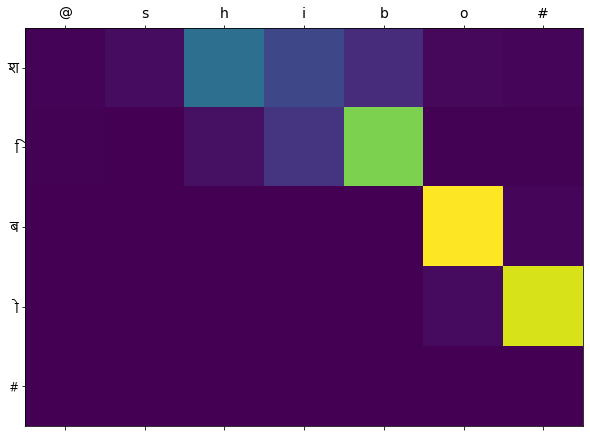

In [82]:
translate("shibo", enc, dec)

In [103]:
def save_predictions(data_frame, name):
    accuracy_count = 0;
    with open(name, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["INPUT", "PREDICTION", "TRUE"])
        for i, (inp, trg) in enumerate(zip(data_frame[1], data_frame[0])): 
            result, sentence, attention_plot = evaluate(inp, enc, dec)
            if i < 20:
                attention_plot = attention_plot[:len(result), :len(sentence)]
                plot_attention(attention_plot, [i for i in sentence], [i for i in result], sentence, result)
            writer.writerow([inp, result[:-1], trg])
            print(inp, result[:-1], trg)
            if result[:-1] == trg:
                accuracy_count += 1
            if (i+1) % 100 == 0 or i+1 == data_frame.size:
                print("Accuracy", (accuracy_count / (i+1)))
                wandb.log({"attn test accuracy": (accuracy_count / (i+1))})

    return accuracy_count/data_frame.size

In [ ]:
# save_predictions(test_df, "1-new_code_with_attn_predictions.csv")